## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions
from functions import get_dictionary_count_lables, count_encoding, unscaler, k_folds_indexs

In [5]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score, roc_curve, auc

### Loading Data

In [6]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [7]:
#['var_0','var_1', 'var_2','var_6','var_12','var_13','var_21','var_22','var_26','var_34',
#                  'var_40','var_53','var_76','var_78','var_80','var_81','var_99','var_109','var_110','var_133',
#                  'var_139','var_146','var_148','var_164','var_165','var_166','var_174','var_190','var_198',]

In [8]:
numerical_features = ['var_0','var_1', 'var_2','var_6','var_12','var_13','var_21','var_22','var_26','var_34',
                  'var_40','var_53','var_76','var_78','var_80','var_81','var_99','var_109','var_110','var_133',
                  'var_139','var_146','var_148','var_164','var_165','var_166','var_174','var_190','var_198',] #'mahalanobis'

<b> random split

In [9]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [10]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [11]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 10000,[True,True], means_train, cov_train )

<b> validation_dataset is ussed as the test set

In [12]:
train_dataset_distance.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    134860
1     15140
Name: mahalanobis, dtype: int64

### Cross validation using K-fold and parameter tunning

In [13]:
dict_1 = {'n':4000, 'range': [0,100], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':10000, 'label': 3, 'category': 1} # augmetation on existing ones
dict_3 = {'n':4000, 'range': [0,100], 'label': 4, 'category': 2} # augmetation on the previous random ones

train_section_aug = augmentation_strategy(data = train_dataset_distance, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)

In [14]:
train_section_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    134860
1     15140
2      4000
3     10000
4      4000
Name: mahalanobis, dtype: int64

<b> scaling

In [15]:
train_dataset_scaled, scalerx = scaler(train_section_aug)

<b> counting encoding

In [16]:
labels_counting = get_dictionary_count_lables(train_section_aug, numerical_features, 30) ### Based on the scale version

In [17]:
train_dataset_encode = count_encoding(train_section_aug, labels_counting, numerical_features)

In [18]:
train_dataset_encode.head()

,target,var_0,var_1,var_2,var_6,var_12,var_13,var_21,var_22,var_26,...,countvar_133,countvar_139,countvar_146,countvar_148,countvar_164,countvar_165,countvar_166,countvar_174,countvar_190,countvar_198
0,0,14.6323,4.4795,9.7187,6.9328,14.0415,10.4034,20.8865,0.6529,7.2176,...,1277,815,397,1760,1798,2000,2021,1972,1519,2161
1,0,6.1434,0.8194,7.7495,5.5317,14.1274,17.5591,16.7864,0.8318,-3.0612,...,1563,1899,1773,1368,1798,1734,627,2089,1805,1716
2,0,14.8377,0.9345,11.6566,4.9043,13.6409,3.6449,17.5242,6.9123,-11.3528,...,1563,1899,176,1078,1288,596,2021,880,1519,2161
3,0,18.5890,-2.3998,13.8151,6.2728,14.3619,11.3760,17.1774,7.1272,-5.3232,...,1284,967,1032,1722,1717,1971,899,433,980,1961
4,0,9.5171,-4.3724,9.4933,5.5936,14.1033,10.0625,16.4844,0.5054,-7.8316,...,455,1700,660,1760,1562,1262,1455,2089,380,1327


<b> Folds

In [19]:
kfolds_touse = k_folds_indexs(train_dataset_encode, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 66000)

In [20]:
train_dataset_encode[train_dataset_encode.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    64895
1    12175
2     4000
3    10000
4     4000
Name: mahalanobis, dtype: int64

In [21]:
len(train_dataset_encode[train_dataset_encode.index.isin(kfolds_touse['fold 3']['train index'])])

95070

<b> tunning strategy

In [22]:
def model_fitting_kfold(models, indexes_kfolds, features, train_data, rate_aug, sample_aug, save_model = False, save_nro_machine = 1 ):
    indexm = 1
    model_results = dict()
    model_saved = list()
    for model,rate_param, sample_param in zip(models,rate_aug, sample_aug) :
        fold_result = dict()
        fold_i = 1
        for fold in indexes_kfolds.keys():
            
            train_index, val_index = indexes_kfolds[fold]['train index'] , indexes_kfolds[fold]['val index']

            validation_data = train_data[train_data.index.isin(val_index)]
            train_data_tomodel = train_data[train_data.index.isin(train_index)]
        
            train_data_tomodel_aug = augmentation_selection_rates(train_data_tomodel, rate = rate_param, sample = sample_param)

            X_train = train_data_tomodel_aug[features]
            Y_train = train_data_tomodel_aug['target']

            X_val = validation_data[features]
            Y_val = validation_data['target']
            
            #### MODEL TRAINING:
            my_model = model.fit(X_train, Y_train)
            if save_model and indexm == save_nro_machine:
                model_saved.append(my_model)
                
            result_metrics, _, _ = metrics_train_validation(my_model, X_train, Y_train, X_val, Y_val)
            
            fold_result[f'fold-{fold_i}'] = {'metrics': result_metrics}
            #print(f'fold {fold_i} done')
            fold_i = fold_i + 1
            
        model_results[f'model-{indexm}'] = fold_result
        print(f'done machine {indexm}')
        indexm = indexm + 1
    return model_results, model_saved

In [23]:
def weighting_models(models, features, data, trained_model = None):
    X_train = data[data.target.isin([0,1])][features]
    Y_train = data[data.target.isin([0,1])]['target']
    probas_result = dict()
    i = 1
    for model in models:    
        probas = model.predict_proba(X_train)[:,1]
        probas_result[i] = probas
    probas_result['target'] = Y_train
    result_df = pd.DataFrame(probas_result)
    X_train = result_df.iloc[:,0:-1]
    Y_train = result_df['target']
    
    if trained_model:
        probas = trained_model.predict_proba(X_train)[:,1]
        return probas
    else:
        weight_model = LogisticRegression().fit(X_train, Y_train)
        return weight_model

In [24]:
#def use_weighted_model(models, features, data):

In [25]:
def jsontotable(json, typex = 'Validation'):
    list_machines, list_folds, list_acc, list_auc = list(), list(), list(),list()
    
    for machine in json.keys():
        machine_json = json[machine]
        for fold in machine_json.keys():
            mets = machine_json[fold]['metrics'][typex]
            Acc, AUC = mets['Accuracy'], mets['AUC']
            list_machines.append(machine), list_folds.append(fold), list_acc.append(Acc), list_auc.append(AUC)
    data = {'machine': list_machines, 'fold' : list_folds , 'Accuracy' : list_acc, 'AUC': list_auc}
    result_data = pd.DataFrame(data)
    return result_data

In [26]:
def plot_results(data):
    fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15,10))

    ax = sns.swarmplot(ax = axs[0] , data = data , x="machine", y="AUC", hue = 'fold')
    ax = sns.swarmplot(ax = axs[1] , data = data , x="machine", y="Accuracy", hue = 'fold')

    fig.show()

In [27]:
features_to_use = list(train_dataset_encode)[1:]

#### Section 1: KNN

In [39]:
my_knn_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
 'neighbors' : [2,4,8,10,15,20],
 'rate_aug': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'sample_aug': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] }

for i in range(number_of_machines):
    neighbors_param = parameters['neighbors'][i]
    my_knn = KNeighborsClassifier(n_neighbors = neighbors_param)
    my_knn_models.append(my_knn)

parameters_df = pd.DataFrame(parameters)    

In [47]:
result_tunning, modelsTrained = model_fitting_kfold(models = my_knn_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 3)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [48]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

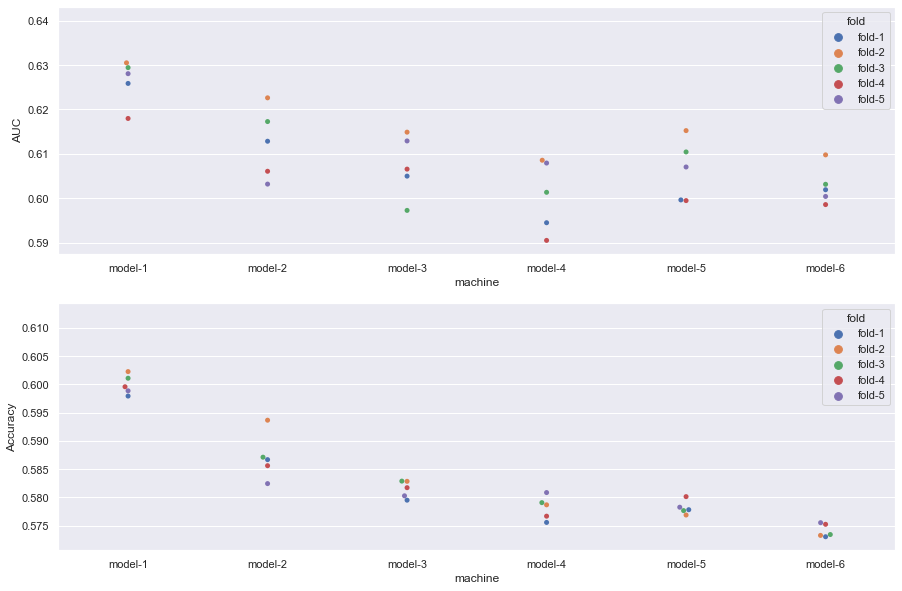

In [49]:
plot_results(toplot_result)

In [51]:
parameters_df[parameters_df.Machine == 'machine-1']

,Machine,neighbors,rate_aug,sample_aug
0,machine-1,2,1.0,0.5


reference bagging

In [52]:
weight_data = train_dataset_encode[train_dataset_encode.target.isin([0,1])]

In [53]:
weighted_model = weighting_models(models = modelsTrained , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained , features = features_to_use, data = weight_data, trained_model = wweighted_model)

In [58]:
roc_auc_score(weight_data.target.values,result)

0.6778136586089278

#### Section 1: Random Forest

In [59]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450],
    'max_depth' : [15, 20, 35, 20, 10, 45],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35 ], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35],
 'rate_aug': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'sample_aug': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [61]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                       rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [63]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

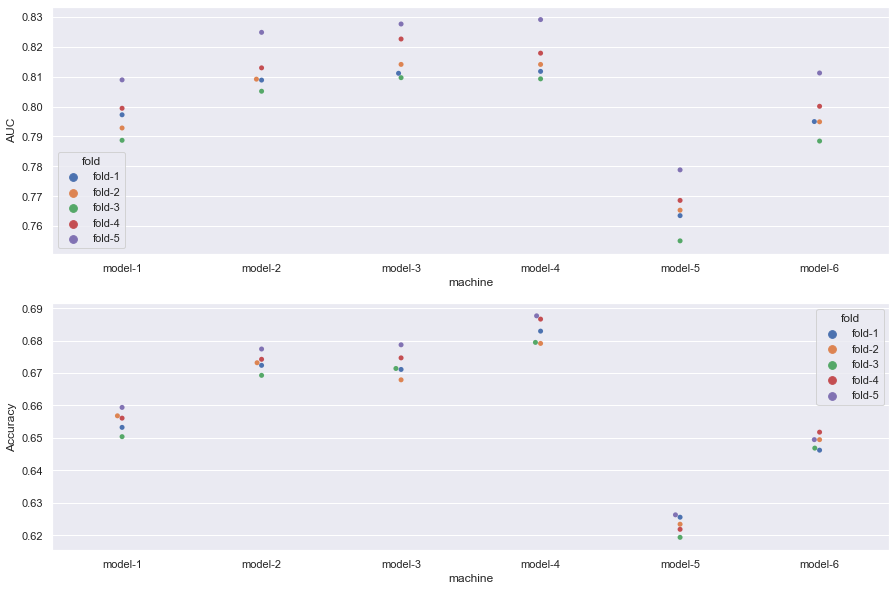

In [64]:
plot_results(toplot_result)

In [65]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.5


#### Section 1: Light Gradient Boosting

In [32]:
my_gbc_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 150, 200, 50, 150, 250],
    'max_depth' : [15, 20, 35, 20, 10, 45],        
    'learning_rate' : [0.001, 0.005, 0.002, 0.003, 0.001, 0.0025 ], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35],
 'rate_aug': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'sample_aug': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    learning_rate_param = parameters['learning_rate'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_gbc = GradientBoostingClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   learning_rate = learning_rate_param, min_samples_leaf = min_samples_leaf_param)
    my_gbc_models.append(my_gbc)

parameters_df = pd.DataFrame(parameters)  

In [33]:
result_tunning = model_fitting_kfold(models = my_gbc_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_dataset_encode,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [34]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

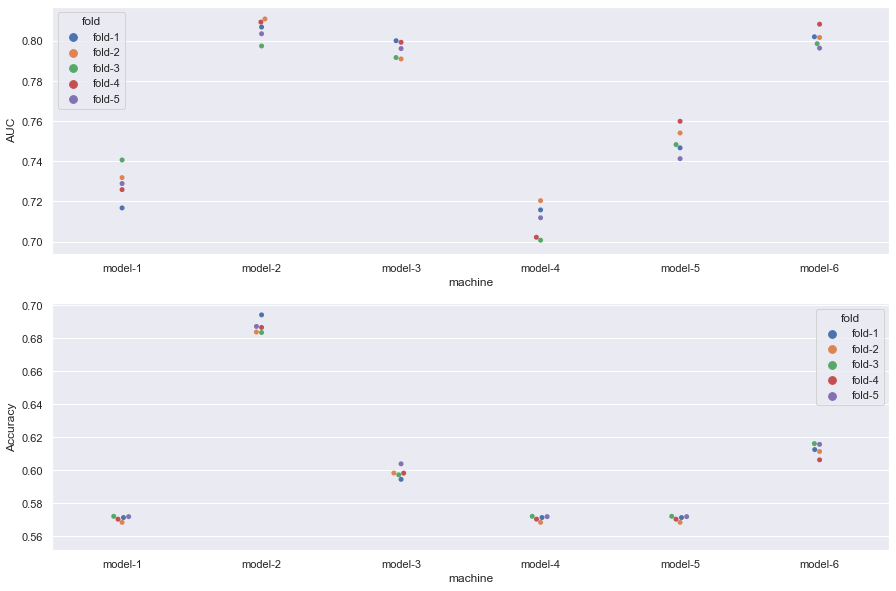

In [35]:
plot_results(toplot_result)

In [36]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,learning_rate,min_samples_leaf,rate_aug,sample_aug
2,machine-3,200,35,0.002,10,1.0,0.5


### Conclusions

* The winners are Random Forest and Gradient Boosting
    + RF is faster than Gradient Boosting Machine
    + seems that GBM performs better that the RF
    + seems that GBM has more stable result than RF
* then go further with hiper parameter tunning
* use the top parameters to continue with the tunning